In [308]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from sympy import Matrix, symbols, eye, zeros, solve, Eq, re, Symbol, atan, pi, exp, sin, cos, sqrt, lambdify, pprint
from numpy import array, arange
import scienceplots


plt.style.use([
    'science',
    'notebook',
    'grid',
    'retro'
])

In [309]:
m1 = 1500
m2 = 100

k1 = 30000   # N/m
k2 = 300000  # N/m

c1 = 500 # Ns/m

M = Matrix([
    [m1, 0],
    [0, m2],
])

K = Matrix([
    [k1, -k1],
    [-k1, k1+k2],
])

C = Matrix([
    [c1, -c1],
    [-c1,  c1],
])

X0 = array([
    [1.0],
    [.0],
])

V0 = array([
    [.0],
    [1.0],
])

N = M.shape[0]

In [310]:
# Calculando M á menos meio
M_minus_half = zeros(N, N)
M_half = zeros(N, N)


for i in range(N):
    M_minus_half[i, i] = (1/sqrt(M[i, i])).evalf()
    M_half[i, i] = (sqrt(M[i, i])).evalf()


# Calculando Ktil
K_til = M_minus_half @ K @ M_minus_half

# Calculando Ctil
C_til = M_minus_half @ C @ M_minus_half

# Encontrando as frequências naturais e amortecidas
lmbd = symbols('lambda')

expr_wn = (K_til - lmbd*eye(N))

eig_wn = solve(expr_wn.det(), lmbd)
wn = [re(sqrt(eig_wn[i])) for i in range(N)]

In [311]:
# Encontrando os auto-vetores normalizados no unitário
norm_syms = [Symbol(f'norm_{i}') for i in range(N)]

X = Matrix(norm_syms)

norm_eq = Eq(
    (X.T@X)[0],
    1
)

P = np.zeros((N, N))
for i in range(N):
    sys_wn = expr_wn.subs(lmbd, eig_wn[i])
    sys = sys_wn @ X

    sol = solve(
        [sys[j] for j in range(N-1)] + [norm_eq],
        norm_syms,
        dict=True
    )[0]

    v = array([
        sol[norm_syms[j]] for j in range(N)
    ])

    P[:, i] = v

# Matriz P

diag_  = P.T @ C_til @ P
zetas  = [diag_[i, i] / (2*wn[i]) for i in range(N)]

wds    = [wn[i] * sqrt(1 - zetas[i]**2) for i in range(N)]

# matrix spectral de P
S = M_minus_half @ P
S_inv = S.inv()

In [312]:
wn

[4.26283365389225, 57.4615371291027]

In [313]:
wds

[4.26061512286938, 57.4058500994680]

In [314]:
P

array([[-0.99972158, -0.02359602],
       [-0.02359602,  0.99972158]])

In [315]:
pprint(S)

⎡-0.0258127000734312   -0.00060924673634716⎤
⎢                                          ⎥
⎣-0.00235960246360377   0.0999721575050461 ⎦


In [316]:
# condições iniciais inversas modais
r_0 = S_inv @ X0
r_dot_0 = S_inv @ V0

pprint(r_0)
print(' ')
pprint(r_dot_0)

⎡-38.7190501101469⎤
⎢                 ⎥
⎣-0.91387010452074⎦
 
⎡-0.235960246360377⎤
⎢                  ⎥
⎣ 9.99721575050462 ⎦


In [317]:
# Calculando as soluções modais desacopladas
t = symbols('t')

r = []

forced_response_forces = Matrix([
    [10000.0],
    [1.0],
])

B = Matrix([
    [1, 0],
    [0, 1],
])

F = P.T @ M_minus_half @ B @ forced_response_forces
wf = 5

for i in range(N):
    w = wn[i]
    wd = wds[i]
    zeta = zetas[i]
    
    r_zero = r_0[i]
    rdot_zero = r_dot_0[i]

    Ai = sqrt(
        ((r_zero * wd)**2 + (rdot_zero + zeta*w*r_zero)**2) / wd**2
    )

    phi_i = atan(
        (r_zero*wd) / (rdot_zero + zeta*w*r_zero)
    )

    if rdot_zero == 0:
        phi_i = pi/2
    
    expr_r = Ai*exp(-zeta*w*t)*sin(wd*t + phi_i)

    f0 = F[i]
    A0 = f0 / sqrt( (w**2 - wf**2)**2 + (2*zeta*w*wf)**2 )
    theta = atan( (2*zeta*w*wf) / (w**2 - wf**2) )
    
    if (w**2 - wf**2) == 0:
        theta = pi/2

    expr_r += A0*cos(wf*t - theta)
    
    r.append(
        expr_r
    )

R = Matrix(r)
pprint(F)

⎡-258.129360336776⎤
⎢                 ⎥
⎣-5.99249520596656⎦


In [318]:
# Retornando ao dominio fisico
x_t = S @ Matrix(r)
x_t.evalf()

sp.simplify(x_t)

Matrix([
[   -0.188854261944475*sin(5*t) + 0.937769837814724*cos(5*t) - 0.00056271589785664*exp(-2.52915471979264*t)*sin(57.405850099468*t - 1.42532572257116) - 1.00001078016393*exp(-0.137511946874024*t)*sin(4.26061512286938*t + 1.53710359412873)],
[-0.0172650448286645*sin(5*t) + 0.0855409347300031*cos(5*t) + 0.0923368464940972*exp(-2.52915471979264*t)*sin(57.405850099468*t - 1.42532572257116) - 0.0914134474035078*exp(-0.137511946874024*t)*sin(4.26061512286938*t + 1.53710359412873)]])

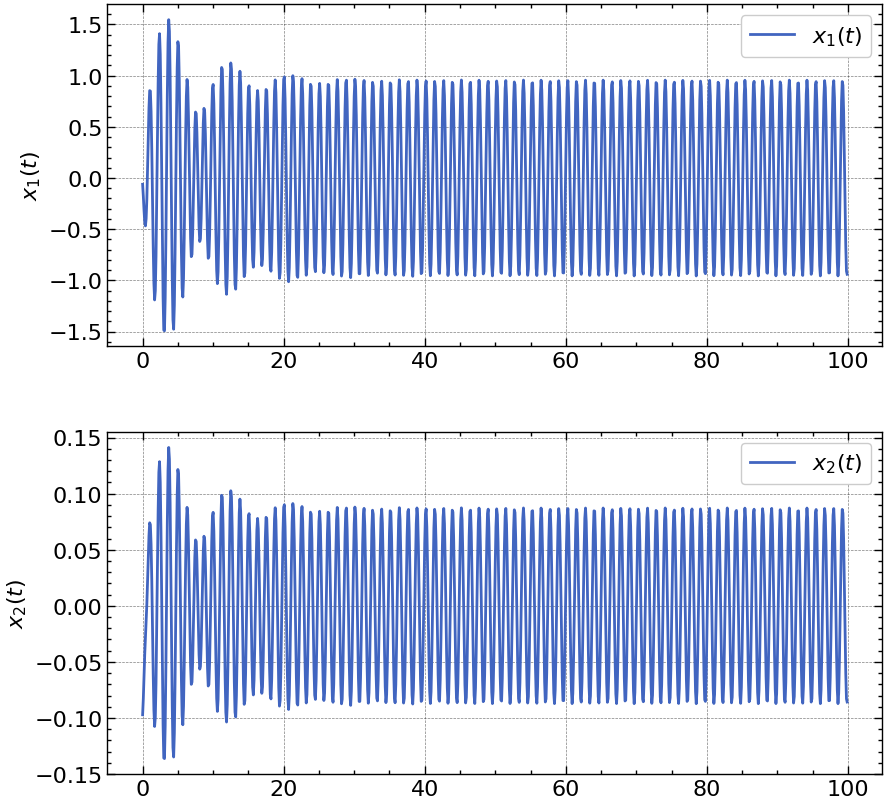

In [319]:
# Simulação

sampling_period = 1e-1
samples = 1000

time = arange(0, samples*sampling_period, sampling_period)

x = [lambdify(t, x_t[i]) for i in range(N)]

xi = [x[i](time) for i in range(N)]

fig, ax = plt.subplots(N, 1, figsize=(10, 10))
plt.subplots_adjust(hspace=0.25)

idx = int(100 / .1)

for i in range(N):
    ax[i].plot(time[:idx], xi[i][:idx], label=f'$x_{i+1}(t)$')
    ax[i].set_ylabel(f'$x_{i+1}(t)$')
    ax[i].legend()

plt.savefig('imagens/forced_response.png', dpi=300)

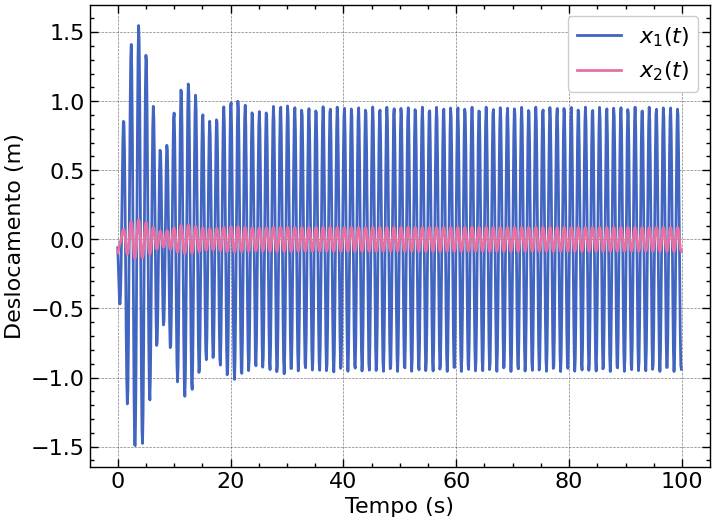

In [320]:
plt.figure()

for i in range(N):
    plt.plot(time[:idx], xi[i][:idx], label=f'$x_{i+1}(t)$')

plt.xlabel('Tempo (s)')
plt.ylabel('Deslocamento (m)')

plt.legend()

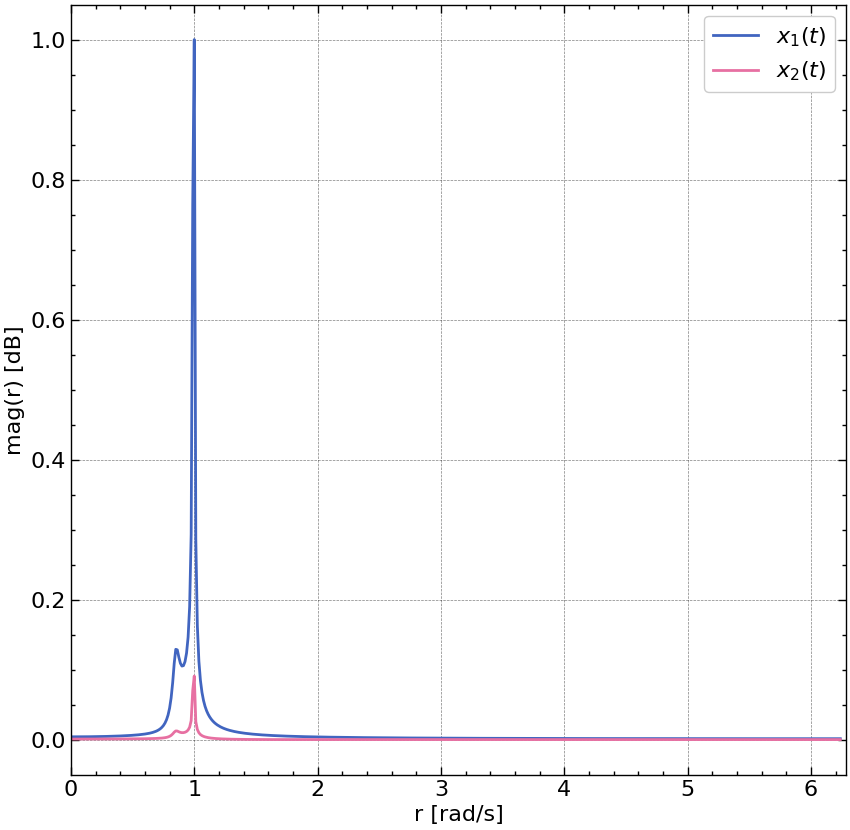

In [321]:
def fft(signal, sampling_time):
    fft = np.fft.fft(signal)
    N = signal.shape[0]

    f = np.fft.fftfreq(len(signal), sampling_time)

    K = N // 2

    freqs = f[:K]*2*np.pi
    amplitudes = np.abs(fft)[:K] * (1 / N)

    phase = np.rad2deg(np.angle(fft)[:K])

    return freqs, amplitudes, phase


ffts   = [fft(xi[i], sampling_period) for i in range(N)]

maximum_amp = np.max([
    np.max(ffts[i][1]) for i in range(N)
])

maximum_freq = np.max(
    [ffts[i][0][np.argmax(ffts[i][1])] for i in range(N)]
)

plt.figure(figsize=(10, 10))

for i in range(N):
    plt.plot(
        ffts[i][0]/maximum_freq,
        ffts[i][1]/maximum_amp,
        label=f'$x_{i+1}(t)$'
    )

plt.xlim(0, 2*np.pi)
plt.xlabel('r [rad/s]')
plt.ylabel('mag(r) [dB]')
plt.legend()